In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer

import pandas as pd
import numpy as np
import re

import nltk
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [2]:
df = pd.read_csv(r"C:\Users\shahv\Downloads\amazon_reviews.csv")
df.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,50423057,R135Q3VZ4DQN5N,B00JWXFDMG,657335467,Everbling Purple and Clear Briolette Drop Swar...,Jewelry,5,0,0,N,Y,Beauties!,so beautiful even tho clearly not high end ......,2015-08-31
1,1,US,11262325,R2N0QQ6R4T7YRY,B00W5T1H9W,26030170,925 Sterling Silver Finish 6ct Simulated Diamo...,Jewelry,5,0,0,N,N,Great product.,"Great product.. I got this set for my mother, ...",2015-08-31
2,2,US,27541121,R3N5JE5Y4T6W5M,B00M2L6KFY,697845240,"Sterling Silver Circle ""Friends Forever"" Infin...",Jewelry,5,0,0,N,Y,Exactly as pictured and my daughter's friend l...,Exactly as pictured and my daughter's friend l...,2015-08-31
3,3,US,5350721,R2I150CX5IVY9Q,B0006SW2WU,569859289,Surgical Stainless Steel Domed 9mm Fishbone Ri...,Jewelry,5,0,0,N,Y,Five Stars,Love it. Fits great. Super comfortable and nea...,2015-08-31
4,4,US,24484424,R1RM9ICOOA9MQ3,B009YPDW70,332947422,"Sterling Silver Family Pendant Necklace, 18""",Jewelry,5,0,0,N,Y,... a Mother's Day gift for my Mom and she lov...,Got this as a Mother's Day gift for my Mom and...,2015-08-31


In [3]:
df = df[['review_body']]

## Preprocessing

In [4]:
df['pre_process'] = df['review_body'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
df.head()

,review_body,pre_process
0,so beautiful even tho clearly not high end ......,so beautiful even tho clearly not high end ......
1,"Great product.. I got this set for my mother, ...","great product.. i got this set for my mother, ..."
2,Exactly as pictured and my daughter's friend l...,exactly as pictured and my daughter's friend l...
3,Love it. Fits great. Super comfortable and nea...,love it. fits great. super comfortable and nea...
4,Got this as a Mother's Day gift for my Mom and...,got this as a mother's day gift for my mom and...


In [5]:
#Remove the HTML tags and URLs from the reviews.
df['pre_process']=df['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())
df['pre_process']=df['pre_process'].apply(lambda x: re.sub(r'http\S+', '', x))
df.head()

C:\Users\shahv\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review_body,pre_process
0,so beautiful even tho clearly not high end ......,so beautiful even tho clearly not high end ......
1,"Great product.. I got this set for my mother, ...","great product.. i got this set for my mother, ..."
2,Exactly as pictured and my daughter's friend l...,exactly as pictured and my daughter's friend l...
3,Love it. Fits great. Super comfortable and nea...,love it. fits great. super comfortable and nea...
4,Got this as a Mother's Day gift for my Mom and...,got this as a mother's day gift for my mom and...


In [6]:
#Removing word contractions
def contractions(s):
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s= re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    return s
df['pre_process']=df['pre_process'].apply(lambda x:contractions(x))
df.head()

,review_body,pre_process
0,so beautiful even tho clearly not high end ......,so beautiful even tho clearly not high end ......
1,"Great product.. I got this set for my mother, ...","great product.. i got this set for my mother, ..."
2,Exactly as pictured and my daughter's friend l...,exactly as pictured and my daughter is friend ...
3,Love it. Fits great. Super comfortable and nea...,love it. fits great. super comfortable and nea...
4,Got this as a Mother's Day gift for my Mom and...,got this as a mother is day gift for my mom an...


In [7]:
#Removing non-alpha characters
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
df.head()

,review_body,pre_process
0,so beautiful even tho clearly not high end ......,so beautiful even tho clearly not high end bu...
1,"Great product.. I got this set for my mother, ...",great product i got this set for my mother a...
2,Exactly as pictured and my daughter's friend l...,exactly as pictured and my daughter is friend ...
3,Love it. Fits great. Super comfortable and nea...,love it fits great super comfortable and nea...
4,Got this as a Mother's Day gift for my Mom and...,got this as a mother is day gift for my mom an...


In [8]:
#Removing extra spaces
df['pre_process']=df['pre_process'].apply(lambda x: re.sub(' +', ' ', x))
df.head()

,review_body,pre_process
0,so beautiful even tho clearly not high end ......,so beautiful even tho clearly not high end but...
1,"Great product.. I got this set for my mother, ...",great product i got this set for my mother as ...
2,Exactly as pictured and my daughter's friend l...,exactly as pictured and my daughter is friend ...
3,Love it. Fits great. Super comfortable and nea...,love it fits great super comfortable and neat ...
4,Got this as a Mother's Day gift for my Mom and...,got this as a mother is day gift for my mom an...


In [9]:
#Removing stopwords
stop = stopwords.words('english')
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
df.head()

,review_body,pre_process
0,so beautiful even tho clearly not high end ......,beautiful even tho clearly high end super grea...
1,"Great product.. I got this set for my mother, ...",great product got set mother allergic bijoux p...
2,Exactly as pictured and my daughter's friend l...,exactly pictured daughter friend loved came pa...
3,Love it. Fits great. Super comfortable and nea...,love fits great super comfortable neat idea fi...
4,Got this as a Mother's Day gift for my Mom and...,got mother day gift mom loved really nice qual...


In [10]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
df.head()

,review_body,pre_process
0,so beautiful even tho clearly not high end ......,beautiful even tho clearly high end super grea...
1,"Great product.. I got this set for my mother, ...",great product got set mother allergic bijou pr...
2,Exactly as pictured and my daughter's friend l...,exactly pictured daughter friend loved came pa...
3,Love it. Fits great. Super comfortable and nea...,love fit great super comfortable neat idea fis...
4,Got this as a Mother's Day gift for my Mom and...,got mother day gift mom loved really nice qual...


## Descriptive Statistics

In [11]:
text = " ".join(review for review in df.pre_process)
split = text.split()

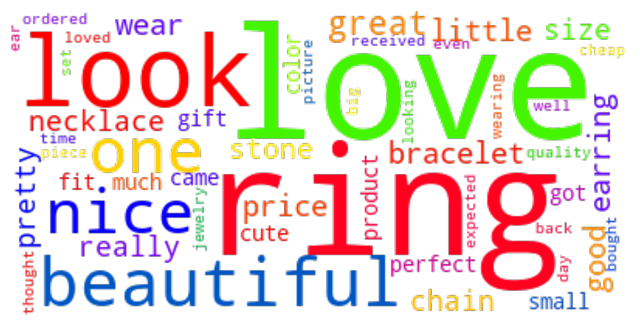

In [12]:
#Wordcloud

stopwords =  set(STOPWORDS)

#Generate a wordcloud image
wordcloud = WordCloud(mode = 'RGBA', max_font_size = 100, stopwords = stopwords, max_words = 50, 
                      background_color = None, colormap='prism_r').generate(text)

#Display the generated image the matplotlib way
plt.imshow(wordcloud, interpolation = 'mitchell')
plt.axis('off')
plt.show()

In [13]:
#Frequency Distribution Table
freq_dist = nltk.FreqDist(split)
freq_dist = pd.DataFrame(freq_dist.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
freq_dist.head()

,word,frequency
60,love,216
99,ring,214
13,look,167
104,like,153
0,beautiful,143


<AxesSubplot:xlabel='frequency', ylabel='word'>

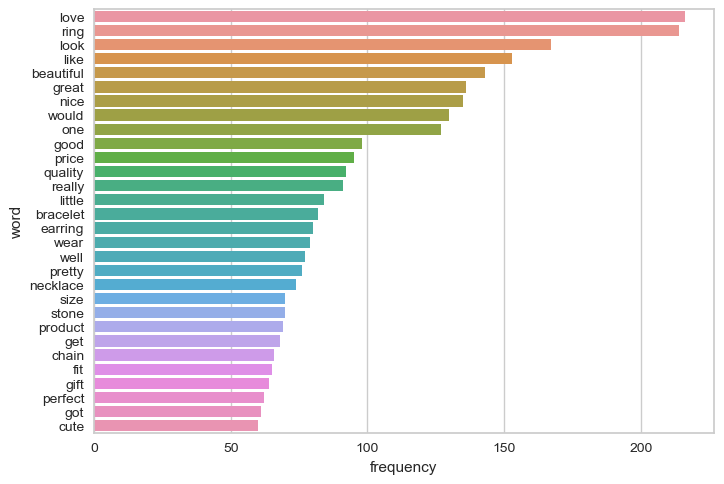

In [14]:
#Frequency Distribution Barplot
sns.barplot(x='frequency',y='word',data=freq_dist.head(30))

## Word Embedding (TF-IDF)

In [15]:
#Reading the reviews column into an array
documents = df.iloc[:,-1].tolist()
documents[:5]

['beautiful even tho clearly high end super great price costume jewelry though others look twice since appear near real nice',
 'great product got set mother allergic bijou probably nickel product know sure know ear get swallowed red itchy unless silver gold glad sterling silver still affordable price never got allergic reaction wear every day',
 'exactly pictured daughter friend loved came packaged nice box thought looked expensive happy purchase',
 'love fit great super comfortable neat idea fish bone also come',
 'got mother day gift mom loved really nice quality interesting design']

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

In [17]:
vectorizer.get_feature_names_out()

array(['able', 'absolutely', 'accent', ..., 'zero', 'zip', 'zodiac'],
      dtype=object)

In [18]:
X

<1000x2192 sparse matrix of type '<class 'numpy.float64'>'
	with 10647 stored elements in Compressed Sparse Row format>

## Model Building

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\shahv\anaconda3\lib\site-

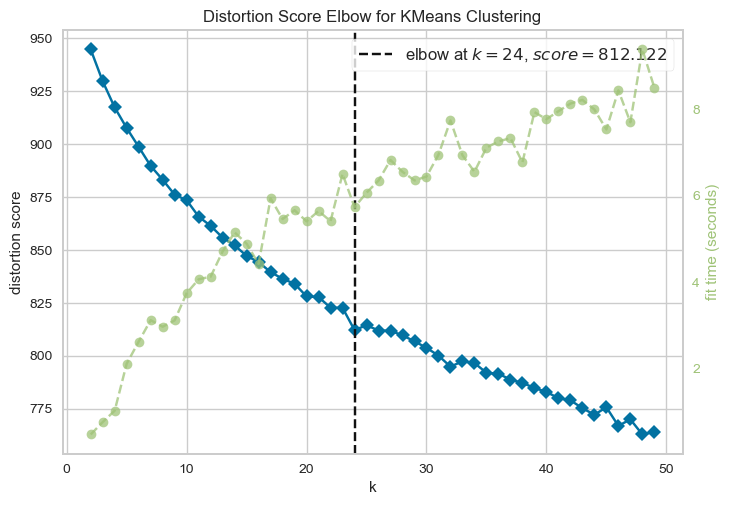

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,50))
visualizer.fit(X)
visualizer.show()

In [33]:
true_k = 22
model = KMeans(n_clusters = true_k, init='k-means++',max_iter = 100 , n_init = 1)
model.fit(X)

KMeans(max_iter=100, n_clusters=22, n_init=1)

## Top 5 Words

In [34]:
print("Top terms per cluster :")
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i,:5]:
        print(' %s' % terms[ind]);
    print

Top terms per cluster :
Cluster 0:
 broke
 day
 first
 wearing
 turn
Cluster 1:
 great
 price
 love
 fit
 look
Cluster 2:
 like
 smaller
 ring
 picture
 really
Cluster 3:
 expected
 smaller
 exactly
 thinner
 bigger
Cluster 4:
 nice
 necklace
 really
 quality
 ty
Cluster 5:
 girl
 prefect
 oldest
 whose
 fight
Cluster 6:
 good
 quality
 price
 really
 look
Cluster 7:
 cheap
 chain
 pendant
 looking
 fell
Cluster 8:
 thanks
 great
 love
 really
 high
Cluster 9:
 cute
 pretty
 necklace
 love
 small
Cluster 10:
 beautiful
 love
 ring
 piece
 necklace
Cluster 11:
 earring
 amazing
 cute
 pretty
 ear
Cluster 12:
 ordered
 gorgeous
 look
 ring
 cost
Cluster 13:
 described
 nice
 product
 ring
 customer
Cluster 14:
 love
 pretty
 daughter
 price
 ring
Cluster 15:
 perfect
 size
 definetely
 love
 pictured
Cluster 16:
 girlfriend
 falling
 loved
 love
 thing
Cluster 17:
 loved
 wife
 sister
 gift
 mom
Cluster 18:
 bracelet
 better
 gift
 would
 love
Cluster 19:
 excellent
 product
 wife
 made


In [35]:
def tag_cluster(doc):
    vec = vectorizer.transform([doc])
    return model.predict(vec)[0]

clusters = [tag_cluster(doc) for doc in documents]

In [37]:
import pandas as pd
data = pd.DataFrame()
data['reviews'] = documents
data['pred'] = clusters
data[-5:]

,reviews,pred
995,anklet nice cute fit ankle beautiful look,9
996,buyer beware stone sent look nothing like pict...,21
997,granddaughter loved,17
998,beautiful quite short,10
999,cheap looking,7


## Cluster Naming

In [62]:
def np_select(df):
    conditions = [df['pred'] == 0,
                  df['pred'] == 1,
                  df['pred'] == 2,
                  df['pred'] == 3,
                  df['pred'] == 4,
                  df['pred'] == 5,
                  df['pred'] == 6,
                  df['pred'] == 7,
                  df['pred'] == 8,
                  df['pred'] == 9,
                  df['pred'] == 10,
                  df['pred'] == 11,
                  df['pred'] == 12,
                  df['pred'] == 13,
                  df['pred'] == 14,
                  df['pred'] == 15,
                  df['pred'] == 16,
                  df['pred'] == 17,
                  df['pred'] == 18,
                  df['pred'] == 19,
                  df['pred'] == 20,
                  df['pred'] == 21]
    outputs = ["Bad Quality","Good Product","Unlike pictures","Different than expected","Great Quality","Unrecognizable","Good look","Bad Quality","Loved by Customers","Good Review","Good Review","Good Review","Worth the cost","Nice Product","Nice Product","Perfect size","Relationship","Family","Gift","Marriage","Unlike pictures","Good product but can be improved"]
    df['label'] = np.select(conditions, outputs, 'Other')
    return df

np_select(data)

,reviews,pred,label
0,beautiful even tho clearly high end super grea...,21,Good product but can be improved
1,great product got set mother allergic bijou pr...,21,Good product but can be improved
2,exactly pictured daughter friend loved came pa...,21,Good product but can be improved
3,love fit great super comfortable neat idea fis...,21,Good product but can be improved
4,got mother day gift mom loved really nice qual...,17,Family
...,...,...,...
995,anklet nice cute fit ankle beautiful look,9,Good Review
996,buyer beware stone sent look nothing like pict...,21,Good product but can be improved
997,granddaughter loved,17,Family
998,beautiful quite short,10,Good Review
